# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs



In [ ]:
!nvidia-smi

Tue Nov 30 18:45:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install Packages

In [ ]:

!pip install torch
!pip install sklearn
!pip install transformers
!pip install rich[jupyter]
!pip install pytorch_lightning
!pip install SentencePiece


     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 49.5 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 214 kB 5.2 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 524 kB 5.4 MB/s 
     |████████████████████████████████| 329 kB 49.6 MB/s 
     |████████████████████████████████| 132 kB 42.9 MB/s 
     |████████████████████████████████| 829 kB 39.0 MB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 
     |████████████████████████████████| 160 kB 48.9 MB/s 
     |████████████████████████████████| 271 kB 47.7 MB/s 
     |████████████████████████████████| 192 kB

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import sys  
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
import simplet5
from simplet5 import SimpleT5
import torch
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration

from sklearn.metrics import f1_score


Global seed set to 42


In [ ]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

# Load the Model (Baseline)

In [ ]:
model= SimpleT5()
model_path = '/content/drive/MyDrive/ROCstory/output/T5base-epoch8-train-1.447.zip (Unzipped Files)/T5base-epoch8-train-1.447'
model.load_model("t5", model_path, use_gpu= True)

# Load val set

In [ ]:
val = pd.read_csv('/content/drive/MyDrive/ROCstory/data/cloze_test_val__winter2018-cloze_test_ALL_val.csv')

In [ ]:
val_output = []
val_cols = ['InputSentence1', 'InputSentence2', 'InputSentence3', 'InputSentence4']
val['combined'] = val[val_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# use the model to generate the output
for index, row in val.iterrows():
  prediction = model.predict(row['combined'])
  val_output.append(prediction)

val['output']= val_output
val = val.explode('output')

In [ ]:
val = val.explode('output')
val.head()

,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output
0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,He started his own gang.
1,bff9f820-9605-4875-b9af-fe6f14d04256,Laverne needs to prepare something for her fri...,She decides to bake a batch of brownies.,She chooses a recipe and follows it closely.,Laverne tests one of the brownies to make sure...,The brownies are so delicious Laverne eats two...,Laverne doesn't go to her friend's party.,1,Laverne needs to prepare something for her fri...,Laverne is happy that she prepared something f...
2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2,Sarah had been dreaming of visiting Europe for...,Sarah decided to stay in Spain until she could...
3,f5226bfe-9f26-4377-b05f-3d9568dbdec1,Gina was worried the cookie dough in the tube ...,She was very happy to find she was wrong.,The cookies from the tube were as good as from...,Gina intended to only eat 2 cookies and save t...,Gina liked the cookies so much she ate them al...,Gina gave the cookies away at her church.,1,Gina was worried the cookie dough in the tube ...,But she ended up eating more than one.
4,69ac9b05-b956-402f-9fff-1f926ef9176b,It was my final performance in marching band.,I was playing the snare drum in the band.,We played Thriller and Radar Love.,The performance was flawless.,I was very proud of my performance.,I was very ashamed of my performance.,1,It was my final performance in marching band....,I was very proud of myself.


# T5 similiarity score

In [ ]:
# load T5 pretained base model
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# apply T5 similarity score
def T5_similarity (y, O):
  input_ids = tokenizer('stsb sentence1: ' + y + ' sentence2: ' + O, return_tensors = 'pt').input_ids
  outputs = model.generate(input_ids)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
def T5_max (y, O1, O2):
  score1 = T5_similarity(y, O1)
  score2 = T5_similarity(y, O2)

  choice = 1 if score1 > score2 else 2
  return choice

In [ ]:
val['T5_SS1'] = val.apply(lambda x: T5_similarity(x['output'],x['RandomFifthSentenceQuiz1']), axis=1)
val['T5_SS2'] = val.apply(lambda x: T5_similarity(x['output'],x['RandomFifthSentenceQuiz2']), axis=1)
val['T5_result'] = val.apply(lambda x: T5_max(x['output'],x['RandomFifthSentenceQuiz1'], x['RandomFifthSentenceQuiz2']), axis=1)

In [ ]:
val_acc_t5 = np.sum(val['T5_result'] == val['AnswerRightEnding'])/len(val['T5_result'])
val_f1_t5 = f1_score(val['AnswerRightEnding'], val['T5_result'])
print('T5 Acc:', val_acc_t5)
print('T5 F1 Score:', val_f1_t5)

T5 Acc 0.7021005728835137
T5 F1 Score 0.6633093525179856


# Universal Sentence Encoder

In [ ]:
#Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  print(corr)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

def USE_similarity(messages_):
  message_embeddings_ = embed(messages_)
  corr = np.inner( message_embeddings_, message_embeddings_)
  score1 = corr[0][1]
  score2 = corr[0][2]
  choice = 1 if score1 > score2 else 2

  return (score1, score2, choice)

In [ ]:
val['messages'] = val.apply(lambda x: list([x['output'],
                                        x['RandomFifthSentenceQuiz1'],
                                        x['RandomFifthSentenceQuiz2']]),axis=1) 
val['USE_similarity'] = val.apply(lambda x: USE_similarity(x['messages']), axis=1)


val.loc[:,'SS1_USE']=val.USE_similarity.map(lambda x:x[0])
val.loc[:,'SS2_USE']=val.USE_similarity.map(lambda x:x[1])
val.loc[:,'result_USE']=val.USE_similarity.map(lambda x:x[2])


In [ ]:
val_acc_USE = np.sum(val['result_USE'] == val['AnswerRightEnding'])/len(val['result_USE'])
val_f1_USE = f1_score(val['AnswerRightEnding'], val['result_USE'])

In [ ]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

# put in dataframe
pd.DataFrame([[now, val_acc_t5,val_f1_t5, val_acc_USE, val_f1_USE]],
             columns=['Data','T5 Acc','T5 F1', 'USE Acc', 'USE F1' ])

,Data,T5 Acc,T5 F1,USE Acc,USE F1
0,2021-11-26 19:41:11.142924,0.702101,0.663309,0.647995,0.655022


In [ ]:
val.to_csv( '/content/drive/MyDrive/ROCstory/output/T5base_epoch8_val.csv')
# val_5.to_csv( '/content/drive/MyDrive/ROCstory/output/epoch8_val_5output.csv')

# Error Analysis

* Categorize the right/wrong prediction
* Bucket rows base on the difference between the similarity scores (T5 & USE)
* Random select 20 examples to do error analysis

# USE Similarity Scores

In [ ]:
val['diff_USE'] = val['SS1_USE'] - val['SS2_USE']
val['final_result_USE'] = (val['result_USE'] != val['AnswerRightEnding'])
val['final_result_USE'] = (val['result_USE'] == val['AnswerRightEnding'])

Final_result_USE to identify if the prediction is correct or not. True represents "Right prediction" and False represnets "Wrong prediction".

In [ ]:
# check examples that is predicted right
val[val['final_result_USE']==True].head()

,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE,diff_USE,final_result_USE
2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2,Sarah had been dreaming of visiting Europe for...,Sarah decided to stay in Spain until she could...,1.6,1.6,2,[Sarah decided to stay in Spain until she coul...,"(0.5864828, 0.62492394, 2)",0.586483,0.624924,2,-0.038441,True
3,f5226bfe-9f26-4377-b05f-3d9568dbdec1,Gina was worried the cookie dough in the tube ...,She was very happy to find she was wrong.,The cookies from the tube were as good as from...,Gina intended to only eat 2 cookies and save t...,Gina liked the cookies so much she ate them al...,Gina gave the cookies away at her church.,1,Gina was worried the cookie dough in the tube ...,But she ended up eating more than one.,1.6,0.0,1,"[But she ended up eating more than one., Gina ...","(0.35522628, 0.19196668, 1)",0.355226,0.191967,1,0.163260,True
4,69ac9b05-b956-402f-9fff-1f926ef9176b,It was my final performance in marching band.,I was playing the snare drum in the band.,We played Thriller and Radar Love.,The performance was flawless.,I was very proud of my performance.,I was very ashamed of my performance.,1,It was my final performance in marching band....,I was very proud of myself.,4.0,0.8,1,"[I was very proud of myself., I was very proud...","(0.79966307, 0.59727407, 1)",0.799663,0.597274,1,0.202389,True
5,d80cabdd-7a85-47e3-86be-5ce6591ca51e,Jim found an old disposable camera in the bott...,He began snapping away at everything around him.,The counter clicked down to one final photo.,The gravity of the situation began to dawn on ...,Jim took time to decide what he would take a p...,Jim took 20 more photos.,1,Jim found an old disposable camera in the bott...,He decided to throw the camera away and get a ...,1.6,0.4,1,[He decided to throw the camera away and get a...,"(0.2797524, 0.16121793, 1)",0.279752,0.161218,1,0.118534,True
7,e17053ac-2046-48c8-a7a2-7b9509c10e64,John and Billy became very skilled at beer pong.,They entered a contest in college.,They won the contest and advanced to the next ...,The next level sent them to Vegas.,"In Vegas, John and Billy competed against eigh...",John and Billy were disappointed.,1,John and Billy became very skilled at beer pon...,They won the contest and went on to win a gold...,1.4,0.4,1,[They won the contest and went on to win a gol...,"(0.37079614, 0.068423934, 1)",0.370796,0.068424,1,0.302372,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,b5bc0ca6-03b0-43c0-8114-20186b5f783b,Trudey wanted to write novels for a living.,She wrote one through traditional publishing m...,It barely made enough to cover the advance she...,She wrote another through self-publishing aven...,Trudey hoped self-publishing would be more pro...,Trudey called her sister and asked her to come...,1,Trudey wanted to write novels for a living. Sh...,Trudey was able to make a decent living doing ...,0.8,0.4,1,[Trudey was able to make a decent living doing...,"(0.3290478, 0.14333567, 1)",0.329048,0.143336,1,0.185712,True
1563,d9dde843-ee66-4dca-820a-c3d489ba586f,Oliver was nervous about his wedding.,He was worried that he would stutter during th...,"When the time came, he took a deep breath and ...","He stuttered, but his wife smiled and hugged h...",Oliver decided to not get married.,Oliver was so grateful for his wife's love.,2,Oliver was nervous about his wedding. He was w...,Oliver was happy to have his wedding day off!,0.8,1.6,2,[Oliver was happy to have his wedding day off!...,"(0.6781114, 0.701

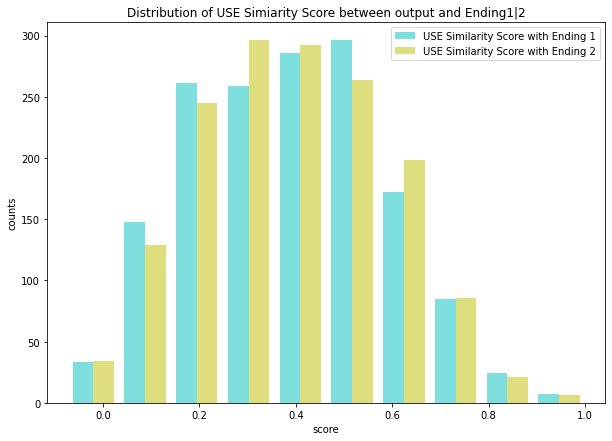

In [ ]:
# plot the Distribution of USE Simiarity Score between output and Ending1|2 (Figure 6 in the research paper)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val['SS1_USE'],val['SS2_USE']],
        label = ['USE Similarity Score with Ending 1', 'USE Similarity Score with Ending 2'],
        color=['c','y'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Distribution of USE Simiarity Score between output and Ending1|2')
plt.xlabel('score')
plt.ylabel('counts')
# Show plot
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


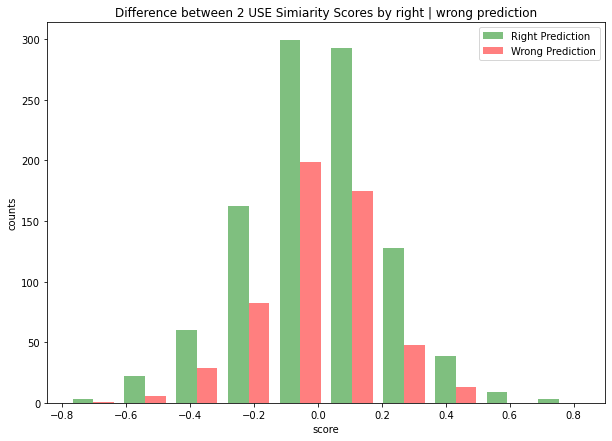

In [ ]:
# plot the Difference between 2 USE Simiarity Scores by right | wrong prediction (Figure 7 in the research paper)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val[val['final_result_USE']==True]['diff_USE'],val[val['final_result_USE']==False]['diff_USE']],
        label = ['Right Prediction', 'Wrong Prediction'],
        color=['g','r'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Difference between 2 USE Simiarity Scores by right | wrong prediction')
plt.xlabel('score')
plt.ylabel('counts')
 
# Show plot
plt.show()

In [ ]:
# bucket results based on the difference between 2 USE similarity scores
wrong_set = val[val['final_result_USE']==False]
wrong_set['diff_USE'] = abs(wrong_set['diff_USE'])
cut_bins = [0,0.2,0.6,1]
bin_labels = ['similar', 'neutral', 'different']
wrong_set['bucket'] = pd.cut(wrong_set['diff_USE'],
                              bins = cut_bins,
                              labels=bin_labels)
wrong_set.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE,diff_USE,final_result_USE,bucket
0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,He started his own gang.,0.0,1.6,2,"[He started his own gang., He is happy now., H...","(0.28910017, 0.7812897, 2)",0.289100,0.781290,2,0.492190,False,neutral
1,bff9f820-9605-4875-b9af-fe6f14d04256,Laverne needs to prepare something for her fri...,She decides to bake a batch of brownies.,She chooses a recipe and follows it closely.,Laverne tests one of the brownies to make sure...,The brownies are so delicious Laverne eats two...,Laverne doesn't go to her friend's party.,1,Laverne needs to prepare something for her fri...,Laverne is happy that she prepared something f...,0.4,1.6,2,[Laverne is happy that she prepared something ...,"(0.30330005, 0.74435127, 2)",0.303300,0.744351,2,0.441051,False,neutral
6,58090d3f-8a91-4c89-83ef-2b4994de9d24,Ron started his new job as a landscaper today.,He loves the outdoors and has always enjoyed w...,His boss tells him to re-sod the front yard of...,"Ron is ecstatic, but does a thorough job and f...",Ron is immediately fired for insubordination.,His boss commends him for a job well done.,2,Ron started his new job as a landscaper today....,Ron is glad he found a new job.,0.0,2.8,2,"[Ron is glad he found a new job., Ron is immed...","(0.5915732, 0.38862675, 1)",0.591573,0.388627,1,0.202946,False,neutral
11,52dbbfda-5b42-4ace-8d59-55cee3eb30c0,Ignacio wants to play a sport while he is in c...,"Since he was a good swimmer, he decides to try...",Ignacio makes it onto the team easily.,"At the first swim meet, Ignacio wins second pl...",Ignacio gave up swimming.,Ignacio won a silver medal.,2,Ignacio wants to play a sport while he is in c...,Ignacio is happy that he decided to play a sport.,1.6,1.6,2,[Ignacio is happy that he decided to play a sp...,"(0.43770754, 0.34924644, 1)",0.437708,0.349246,1,0.088461,False,similar
15,aa615e4f-83c1-4b65-96a4-6a989d253a52,Jesse had just started fifth grade.,"He tried to make friends with the other boys, ...",He decided to make friends with the girls inst...,They girls welcomed him into their social grou...,"Jesse went to the park with his new friend, Ro...",Jesse was picked on by the other boys in school.,2,Jesse had just started fifth grade. He tried t...,Jesse was glad he had made friends with the gi...,1.6,0.4,1,[Jesse was glad he had made friends with the g...,"(0.621917, 0.54271865, 1)",0.621917,0.542719,1,0.079198,False,similar


In [ ]:
# calculate the percentage in each bucket
wrong_set.bucket.value_counts() / len(wrong_set)

similar      0.755877
neutral      0.242315
different    0.001808
Name: bucket, dtype: float64

75% of val examples have very similar USE similarity scores. We need to find more complicated evaluation methods.

In [ ]:
wrong_set[wrong_set['diff_USE'] == 0]

,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE,diff_USE,final_result_USE,bucket


USE sentence similarity scores are calcuated by inner product of vectors. The pro is that it does not have 0 similarity scores like T5 does. 

In [ ]:
# output to csv to be further analyzed 
wrong_set.to_csv('/content/drive/MyDrive/ROCstory/output/use_wrong_set.csv')

# T5 Similarity Scores

T5 is text-to-text model and we will need to transfer our similarity scores from the string to float.

In [ ]:
val['T5_SS1'] = val['T5_SS1'].astype(float)
val['T5_SS2'] = val['T5_SS2'].astype(float)
val['diff_t5'] = val['T5_SS1'] - val['T5_SS2']
val['final_result_t5'] = (val['T5_result'] != val['AnswerRightEnding'])
val['final_result_t5'] = (val['T5_result'] == val['AnswerRightEnding'])

In [ ]:
print(len(val.loc[(val['T5_SS1'] == 0)]) / len(val))
print(len(val.loc[(val['T5_SS2'] == 0)]) / len(val))
print(len(val.loc[(val['T5_SS1'] == 0) & (val['T5_SS2'] == 0)]) / len(val))

0.3303628262253342
0.32017823042647997
0.1343093570973902


* 33% of val cases have zero T5 similarity scores between output and ending 1.
* 32% of val cases have zero T5 similarity scores between output and ending 2.
* 13% of val cases have zero T5 similarity scores between output and both endings.
* It indicates that 3 sentences are talking about 3 different things, because the next sentence prediction could be various.

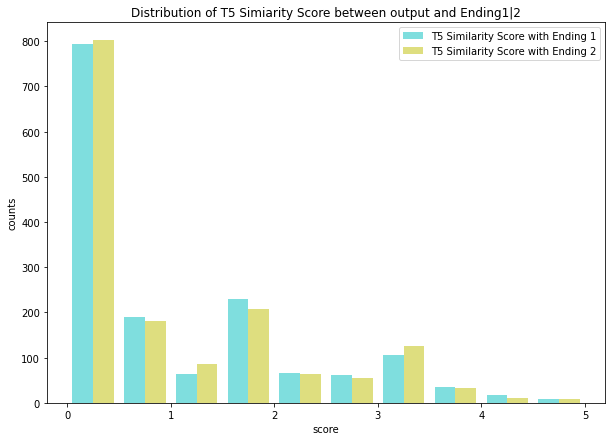

In [ ]:
# plot Distribution of T5 Simiarity Score between output and Ending1|2 (Figure 4 in the research paper)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val['T5_SS1'],val['T5_SS2']],
        label = ['T5 Similarity Score with Ending 1', 'T5 Similarity Score with Ending 2'],
        color=['c','y'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Distribution of T5 Simiarity Score between output and Ending1|2')
plt.xlabel('score')
plt.ylabel('counts')
# Show plot
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


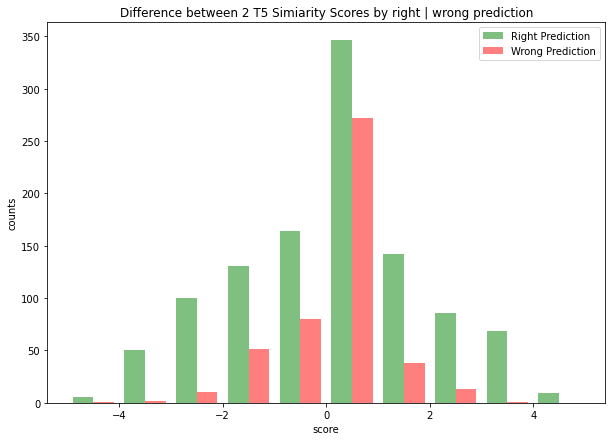

In [ ]:
# plot Difference between 2 T5 Simiarity Scores by right | wrong prediction (Figure 5 in the research paper)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val[val['final_result_t5']==True]['diff_t5'],val[val['final_result_t5']==False]['diff_t5']],
        label = ['Right Prediction', 'Wrong Prediction'],
        color=['g','r'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Difference between 2 T5 Simiarity Scores by right | wrong prediction')
plt.xlabel('score')
plt.ylabel('counts')
 
# Show plot
plt.show()

In [ ]:
wrong_set_t5 = val[val['final_result_t5']==False]
len(wrong_set_t5[wrong_set_t5['diff_t5'] == 0])

198

In [ ]:
len(wrong_set_t5)

468

In [ ]:
len(wrong_set_t5[wrong_set_t5['diff_t5'] == 0])/len(wrong_set_t5)

0.4230769230769231

Among the wrong prediction cases, 42% of them have the same T5 similarity score. We need to introduce sentiment analysis to differ.

In [ ]:
# output to have further analysis
val.to_csv('val_base.csv')

# Error Analysis After Applying 5 Outputs and Simi-Senti Scores


In [ ]:
val_5 = pd.read_csv('/content/drive/MyDrive/ROCstory/output/Val final/epoch8_val_5output.csv')

In [ ]:
val_5.head()

,Unnamed: 0,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,cos_result,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE
0,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,He started his own gang.,2,0.0,1.6,2,"['He started his own gang.', 'He is happy now....","(0.28910017, 0.7812897, 2)",0.289100,0.781290,2
1,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"Now, Rick lives in a homeless shelter.",2,0.4,0.0,1,"['Now, Rick lives in a homeless shelter.', 'He...","(0.1753709, 0.15250778, 1)",0.175371,0.152508,1
2,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a drug add...",2,0.0,1.6,2,"['He started his own gang, and became a drug a...","(0.13219982, 0.59830046, 2)",0.132200,0.598300,2
3,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a hermit.",2,0.0,1.6,2,"['He started his own gang, and became a hermit...","(0.19345042, 0.56074643, 2)",0.193450,0.560746,2
4,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a drug dea...",2,0.0,1.6,2,"['He started his own gang, and became a drug d...","(0.16200918, 0.62089217, 2)",0.162009,0.620892,2


In [ ]:
!pip install flair

     |████████████████████████████████| 322 kB 4.8 MB/s 
     |████████████████████████████████| 64 kB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 981 kB 40.8 MB/s 
     |████████████████████████████████| 788 kB 40.1 MB/s 
     |████████████████████████████████| 1.2 MB 37.8 MB/s 
     |████████████████████████████████| 19.7 MB 940 kB/s 
     |████████████████████████████████| 62 kB 809 kB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=807cdf5c0fbc741b87e97a6a508a713111f1e42a59717d168981993391588e8a
  Stored in directory: /root/.cache/pip/wheels/ba/e0/7e/726e872a53f7358b4b96a9975b04e98113b005cd8609a63abc
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=1c43ae9916bd71d6faa7d20202aa715f05cc80f6567e1f6056d337913ee5a03f
  Stored in dir

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
classifier = TextClassifier.load('en-sentiment')

2021-12-01 04:01:27,919 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpln_zevst


100%|██████████| 265512723/265512723 [00:12<00:00, 20550466.38B/s]

2021-12-01 04:01:41,218 copying /tmp/tmpln_zevst to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-01 04:01:41,765 removing temp file /tmp/tmpln_zevst
2021-12-01 04:01:41,806 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def get_label (input):
  sentences = result.apply(lambda x: Sentence(x[input]), axis=1)
  sentences.apply(lambda x:classifier.predict(x))
  labels = sentences.apply(lambda x: x.labels)
  labels = labels.apply(lambda x: str(x[0]).split()[0])
  return labels

In [ ]:
val_5['output_sentiment'] = get_label('output')
val_5['ending1_sentiment'] = get_label('RandomFifthSentenceQuiz1')
val_5['ending2_sentiment'] = get_label('RandomFifthSentenceQuiz2')

In [ ]:
val_5['ending1_sentiment_result'] = (val_5['ending1_sentiment'] == val_5['output_sentiment']).astype(int) 
val_5['ending2_sentiment_result'] = (val_5['ending2_sentiment'] == val_5['output_sentiment']).astype(int)

val_5['T5_sentiment1'] = val_5['T5_SS1'] + 1* val_5['ending1_sentiment_result']
val_5['T5_sentiment2'] = val_5['T5_SS2'] + 1* val_5['ending2_sentiment_result']

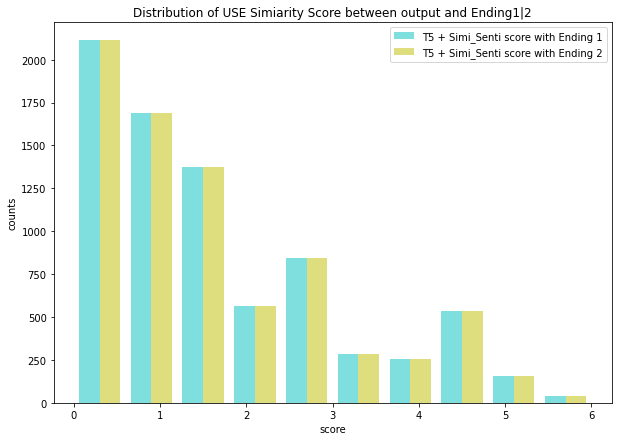

In [ ]:
# Plot the same graphs as above for 5 outputs
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val_5['T5_sentiment1'],val_5['T5_sentiment1']],
        label = ['T5 + Simi_Senti score with Ending 1', 'T5 + Simi_Senti score with Ending 2'],
        color=['c','y'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Distribution of USE Simiarity Score between output and Ending1|2')
plt.xlabel('score')
plt.ylabel('counts')
# Show plot
plt.show()

In [ ]:
from random import randint, choice

import random
def t5_max(s1, s2, a1, a2):
  if s1 > s2:
    return 1
  elif s1 < s2:
    return 2
  else:
    if a1 > a2:
      return 1
    elif a1 < a2:
      return 2
val_5['T5_senti_result'] = val_5.apply(lambda x: t5_max(x['T5_sentiment1'], x['T5_sentiment2'], x['SS1_USE'], x['SS2_USE']), axis = 1)

In [ ]:
t5_senti_result= val_5.groupby(['combined', 'T5_senti_result']).size().to_frame('t5_count').reset_index()
idx = t5_senti_result.groupby(['combined'])['t5_count'].transform(max) == t5_senti_result['t5_count']
t5_senti_result = t5_senti_result[idx]

In [ ]:
t5_senti_result

,combined,T5_senti_result,t5_count
0,A bar owner put out a large banner to advertis...,1,5
1,A beautiful bunch of bananas dangled just out ...,2,5
2,A boy Jack had been asking his parents to get ...,2,5
3,A boy needed to learn to drive. He asked his f...,2,5
4,A boy saw a quarter lying on the sidewalk. He ...,2,5
...,...,...,...
2110,Yvonne had always been overweight. For New Yea...,1,5
2111,Zack and his friends passed a scary house on t...,2,5
2112,Zeke was throwing a Halloween party. All his f...,1,3
2114,Zeke was tired of living in America. He decide...,2,5


In [ ]:
val_5 = val_5.merge(t5_senti_result, on = 'combined', how = 'left')

In [ ]:
val_5.head()

,Unnamed: 0,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,cos_result,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE,output_sentiment,ending1_sentiment,ending2_sentiment,ending1_sentiment_result,ending2_sentiment_result,T5_sentiment1,T5_sentiment2,T5_senti_result_x,T5_senti_result_y,t5_count
0,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,He started his own gang.,2,0.0,1.6,2,"['He started his own gang.', 'He is happy now....","(0.28910017, 0.7812897, 2)",0.289100,0.781290,2,NEGATIVE,POSITIVE,NEGATIVE,0,1,0.0,2.6,2,2,5
1,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"Now, Rick lives in a homeless shelter.",2,0.4,0.0,1,"['Now, Rick lives in a homeless shelter.', 'He...","(0.1753709, 0.15250778, 1)",0.175371,0.152508,1,NEGATIVE,POSITIVE,NEGATIVE,0,1,0.4,1.0,2,2,5
2,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a drug add...",2,0.0,1.6,2,"['He started his own gang, and became a drug a...","(0.13219982, 0.59830046, 2)",0.132200,0.598300,2,NEGATIVE,POSITIVE,NEGATIVE,0,1,0.0,2.6,2,2,5
3,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a hermit.",2,0.0,1.6,2,"['He started his own gang, and became a hermit...","(0.19345042, 0.56074643, 2)",0.193450,0.560746,2,POSITIVE,POSITIVE,NEGATIVE,1,0,1.0,1.6,2,2,5
4,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a drug dea...",2,0.0,1.6,2,"['He started his own gang, and became a drug d...","(0.16200918, 0.62089217, 2)",0.162009,0.620892,2,NEGATIVE,POSITIVE,NEGATIVE,0,1,0.0,2.6,2,2,5


In [ ]:
val_5['diff_t5_senti'] = val_5['T5_sentiment1'] - val_5['T5_sentiment2']
val_5['final_result_t5_senti'] = (val_5['T5_senti_result_x'] != val_5['AnswerRightEnding'])
val_5['final_result_t5_senti'] = (val_5['T5_senti_result_x'] == val_5['AnswerRightEnding'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


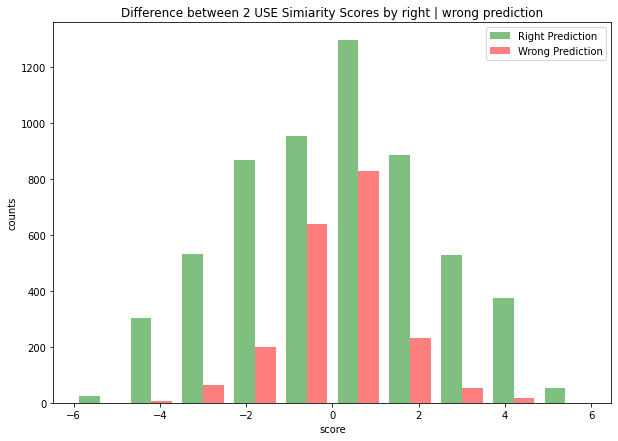

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val_5[val_5['final_result_t5_senti']==True]['diff_t5_senti'],val_5[val_5['final_result_t5_senti']==False]['diff_t5_senti']],
        label = ['Right Prediction', 'Wrong Prediction'],
        color=['g','r'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Difference between 2 USE Simiarity Scores by right | wrong prediction')
plt.xlabel('score')
plt.ylabel('counts')
 
# Show plot
plt.show()

In [ ]:
val_5.to_csv('val_5_output_final.csv')

# USE Similarity Scores

In [ ]:
val_5['diff_USE'] = val_5['SS1_USE'] - val_5['SS2_USE']
val_5['final_result_USE'] = (val_5['result_USE'] != val_5['AnswerRightEnding'])
val_5['final_result_USE'] = (val_5['result_USE'] == val_5['AnswerRightEnding'])

In [ ]:
val_5[val_5['final_result_USE']==True]

,Unnamed: 0,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,cos_result,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE,T5_senti_result,t5_count,diff_USE,final_result_USE
1,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"Now, Rick lives in a homeless shelter.",2,0.4,0.0,1,"['Now, Rick lives in a homeless shelter.', 'He...","(0.1753709, 0.15250778, 1)",0.175371,0.152508,1,2,5,0.022863,True
10,2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2,Sarah had been dreaming of visiting Europe for...,Sarah decided she would never go back.,2,1.4,2.4,2,"['Sarah decided she would never go back.', 'Sa...","(0.5580535, 0.61065066, 2)",0.558053,0.610651,2,2,4,-0.052597,True
11,2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2,Sarah had been dreaming of visiting Europe for...,"However, she was happy to finally be in Europe.",1,2.2,1.6,1,"['However, she was happy to finally be in Euro...","(0.37345934, 0.38286132, 2)",0.373459,0.382861,2,2,4,-0.009402,True
12,2,e8f628d5-9f97-40ed-8611-fc0e774673c4,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...,2,Sarah had been dreaming of visiting Europe for...,Sarah decided to stay in Spain until she could...,1,1.6,1.6,2,['Sarah decided to stay in Spain until she cou...,"(0.5864828, 0.62492394, 2)",0.586483,0.624924,2,2,4,-0.038441,True
15,3,f5226bfe-9f26-4377-b05f-3d9568dbdec1,Gina was worried the cookie dough in the tube ...,She was very happy to find she was wrong.,The cookies from the tube were as good as from...,Gina intended to only eat 2 cookies and save t...,Gina liked the cookies so much she ate them al...,Gina gave the cookies away at her church.,1,Gina was worried the cookie dough in the tube ...,"When she ate the first cookie, she realized sh...",1,1.6,1.6,2,"['When she ate the first cookie, she realized ...","(0.5954293, 0.48026562, 1)",0.595429,0.480266,1,1,3,0.115164,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7850,1570,34ddd737-0709-4fc7-b64b-6c43eaf9f48c,I wanted to buy a video game console.,"I asked my parents, and they came up with an i...","They said if I did my chores, I would be given...",I did my chores without being asked every week...,My parents gave me enough money to buy the con...,At the end of the summer I gave the money back...,1,I wanted to buy a video game console. I asked ...,Now I have enough money to buy the console!,1,3.2,0.0,1,['Now I have enough money to buy the console!'...,"(0.7188125, 0.20231202, 1)",0.718813,0.202312,1,1,5,0.516501,True
7851,1570,34ddd737-0709-4fc7-b64b-6c43eaf9f48c,I wanted to buy a video game console.,"I asked my parents, and they came up with an i...","They said if I did my chores, I would be given...",I did my chores without being asked every week...,My parents gave me enough money to buy the con...,At the end of the summer I gave the money back...

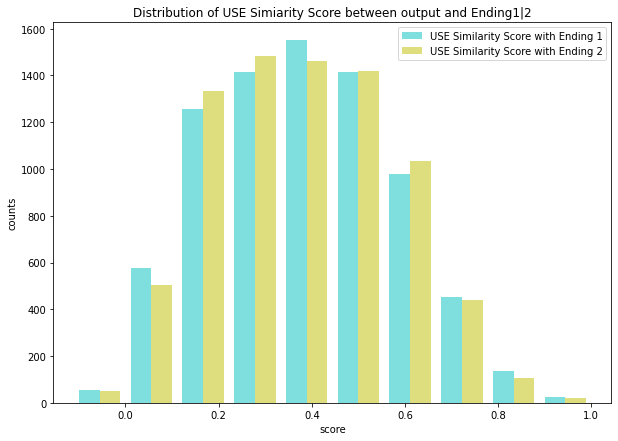

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val_5['SS1_USE'],val_5['SS2_USE']],
        label = ['USE Similarity Score with Ending 1', 'USE Similarity Score with Ending 2'],
        color=['c','y'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Distribution of USE Simiarity Score between output and Ending1|2')
plt.xlabel('score')
plt.ylabel('counts')
# Show plot
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


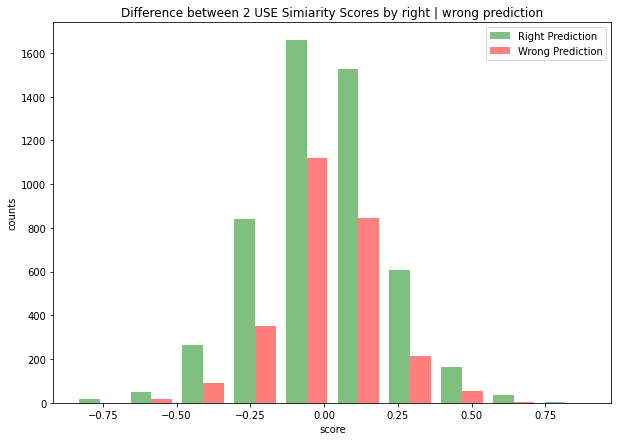

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val_5[val_5['final_result_USE']==True]['diff_USE'],val_5[val_5['final_result_USE']==False]['diff_USE']],
        label = ['Right Prediction', 'Wrong Prediction'],
        color=['g','r'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Difference between 2 USE Simiarity Scores by right | wrong prediction')
plt.xlabel('score')
plt.ylabel('counts')
 
# Show plot
plt.show()

In [ ]:
val_5.to_csv('/content/drive/MyDrive/ROCstory/output/Val final/val_5output_senti.csv')

In [ ]:
wrong_set = val_5[val_5['final_result_USE']==False]
wrong_set['diff_USE'] = abs(wrong_set['diff_USE'])
cut_bins = [0,0.2,0.6,1]
bin_labels = ['similar', 'neutral', 'different']
wrong_set['bucket'] = pd.cut(wrong_set['diff_USE'],
                              bins = cut_bins,
                              labels=bin_labels)
wrong_set.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Unnamed: 0,InputStoryid,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2,AnswerRightEnding,combined,output,cos_result,T5_SS1,T5_SS2,T5_result,messages,USE_similarity,SS1_USE,SS2_USE,result_USE,T5_senti_result,t5_count,diff_USE,final_result_USE,bucket
0,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,He started his own gang.,2,0.0,1.6,2,"['He started his own gang.', 'He is happy now....","(0.28910017, 0.7812897, 2)",0.289100,0.781290,2,2,5,0.492190,False,neutral
2,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a drug add...",2,0.0,1.6,2,"['He started his own gang, and became a drug a...","(0.13219982, 0.59830046, 2)",0.132200,0.598300,2,2,5,0.466101,False,neutral
3,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a hermit.",2,0.0,1.6,2,"['He started his own gang, and became a hermit...","(0.19345042, 0.56074643, 2)",0.193450,0.560746,2,2,5,0.367296,False,neutral
4,0,138d5bfb-05cc-41e3-bf2c-fa85ebad14e2,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.,1,Rick grew up in a troubled household. He never...,"He started his own gang, and became a drug dea...",2,0.0,1.6,2,"['He started his own gang, and became a drug d...","(0.16200918, 0.62089217, 2)",0.162009,0.620892,2,2,5,0.458883,False,neutral
5,1,bff9f820-9605-4875-b9af-fe6f14d04256,Laverne needs to prepare something for her fri...,She decides to bake a batch of brownies.,She chooses a recipe and follows it closely.,Laverne tests one of the brownies to make sure...,The brownies are so delicious Laverne eats two...,Laverne doesn't go to her friend's party.,1,Laverne needs to prepare something for her fri...,Laverne is happy that she prepared something f...,2,1.6,1.2,1,['Laverne is happy that she prepared something...,"(0.32554862, 0.52743554, 2)",0.325549,0.527436,2,1,4,0.201887,False,neutral


In [ ]:
wrong_set.bucket.value_counts() / len(wrong_set)

similar      0.783352
neutral      0.214790
different    0.001858
Name: bucket, dtype: float64

For 5 ouputs, 78% of val examples have very similar USE similarity scores.

# T5 Similarity Scores

In [ ]:
val_5['T5_SS1'] = val_5['T5_SS1'].astype(float)
val_5['T5_SS2'] = val_5['T5_SS2'].astype(float)
val_5['diff_t5'] = val_5['T5_SS1'] - val_5['T5_SS2']
val_5['final_result_t5'] = (val_5['T5_result'] != val_5['AnswerRightEnding'])
val_5['final_result_t5'] = (val_5['T5_result'] == val_5['AnswerRightEnding'])

In [ ]:
print(len(val_5.loc[(val_5['T5_SS1'] == 0)]) / len(val_5))
print(len(val_5.loc[(val_5['T5_SS2'] == 0)]) / len(val_5))
print(len(val_5.loc[(val_5['T5_SS1'] == 0) & (val_5['T5_SS2'] == 0)]) / len(val_5))

0.3331635900700191
0.3232336091661362
0.12947167409293445


* 32% of val cases have zero T5 similarity scores between output and ending 1.
* 32% of val cases have zero T5 similarity scores between output and ending 2.
* 13% of val cases have zero T5 similarity scores between output and both endings.
* It indicates that add more output did not really change the distribution and it is still that 3 sentences are talking about 3 different things, because the next sentence prediction could be various.

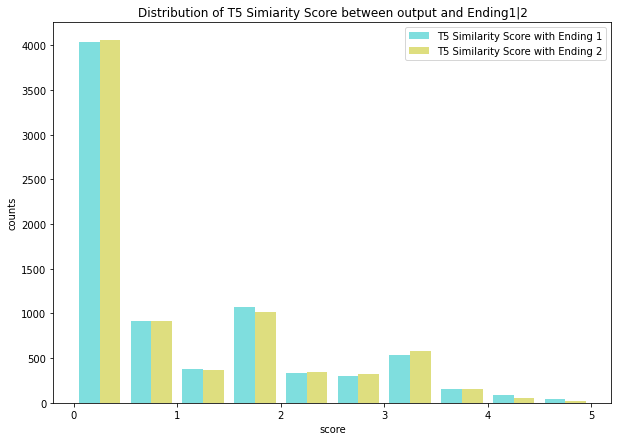

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val_5['T5_SS1'],val_5['T5_SS2']],
        label = ['T5 Similarity Score with Ending 1', 'T5 Similarity Score with Ending 2'],
        color=['c','y'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Distribution of T5 Simiarity Score between output and Ending1|2')
plt.xlabel('score')
plt.ylabel('counts')
# Show plot
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


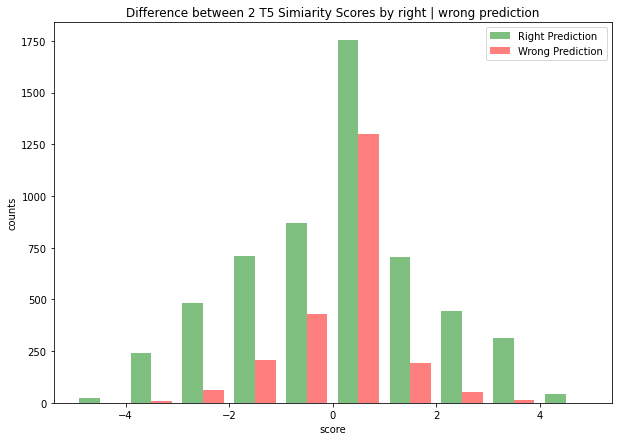

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val_5[val_5['final_result_t5']==True]['diff_t5'],val_5[val_5['final_result_t5']==False]['diff_t5']],
        label = ['Right Prediction', 'Wrong Prediction'],
        color=['g','r'],
        alpha=0.5)
plt.legend(loc='upper right')

plt.title('Difference between 2 T5 Simiarity Scores by right | wrong prediction')
plt.xlabel('score')
plt.ylabel('counts')
 
# Show plot
plt.show()

In [ ]:
wrong_set_t5 = val_5[val_5['final_result_t5']==False]
len(wrong_set_t5[wrong_set_t5['diff_t5'] == 0])

945

In [ ]:
len(wrong_set_t5)

2267

In [ ]:
len(wrong_set_t5[wrong_set_t5['diff_t5'] == 0])/len(wrong_set_t5)

0.4168504631671813

Among the wrong prediction cases, 42% of them have the same T5 similarity score. It proves again that adding 5 outputs did not really help in that perspectives. It is also the reason why we introduce the Simi-Senti scores, which compares T5 similarity scores first. If they are the same, we use the USE scores, and then add weighted sentiment scores. Experiments showed 6.6% accuracy improvement for val set. 